# Day05

今回はwine dataset を使用して、データの次元削減を説明する。  
まずは、wine dataset のデータフレームを作成する。

In [1]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


学習用、テスト用に分割した後に標準化しておく。

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## 主成分分析(PCA)
### 共分散行列
データの標準化が完了したら、特徴量ごとの相関行列を作成する。  
相関行列の作成には、`numpy`の`cov`関数を利用すると$n \times n$の形状の共分散行列ができる。(wine dataset の特徴量は13次元)

In [3]:
import numpy as np

# 共分散行列
cov_mat = np.cov(X.T)
cov_mat.shape

(13, 13)

### 固有値と固有ベクトル

共分散行列をもとに、固有値と固有ベクトルを計算する。  
計算には`numpy`の`eig`関数を利用する。  
ここで、`eigen_vals`が固有値、`eigen_vecs`が固有ベクトルである。

In [4]:
# 固有値, 固有ベクトル
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

これらをまとめてPCAクラスとして主成分分析を実装すると次のようになる

In [5]:
import numpy as np

class PCA:
    def __init__(self, n_components:int=2):
        # 変換後の次元数を設定
        self.k = n_components
    
    def fit_transform(self, X:np.ndarray) -> np.ndarray:
        
        # 共分散行列
        cov_mat = np.cov(X.T)
        
        # 固有値, 固有ベクトル
        eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
        
        
        #　(固有値, 固有ベクトル) のリストを作成
        eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
                    for i in range(len(eigen_vals))]

        # 固有値を基準に降順にソート
        eigen_pairs.sort(key=lambda k: k[0], reverse=True)
        
        # ソート済みの固有値を上からk個積み重ねた射影行列を作成
        w = np.hstack([eigen_pairs[i][1][:, np.newaxis] for i in range(self.k)])
        
        return X_train @ w

### 次元削減
作成したPCAクラスを使用して、主成分分析を行う。  
結果を見ると、13次元あった特徴量が二次元空間に分別しやすそうな形に射影されている事がわかる。

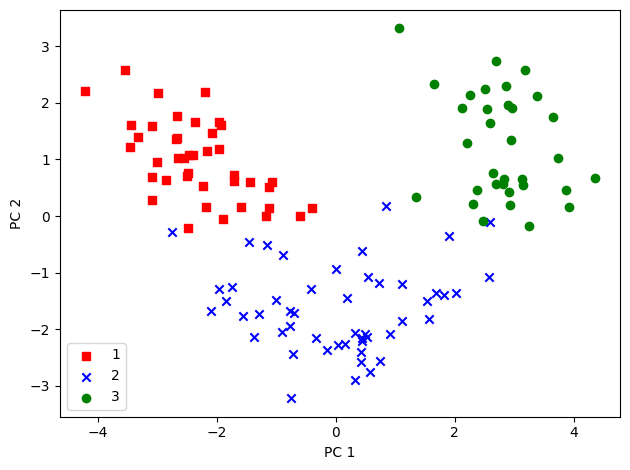

In [6]:
import numpy as np
import matplotlib.pyplot as plt


# 作成したPCAクラスで主成分分析
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)


# プロット
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### scikit-learnを使用したPCAの実装
PCAはscikit-leaarnでも実装されている。自作のPCAと似たような結果になることが確認できる。

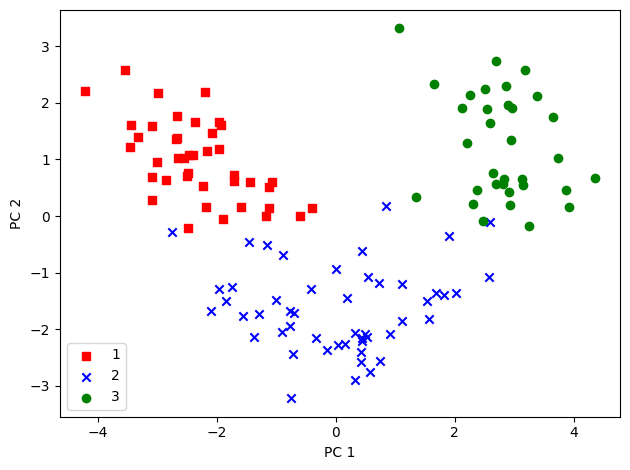

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# プロット
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### PCAを利用したロジスティック回帰

In [8]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

print('Accuracy: %.3f' % lr.score(X_test_pca, y_test))

Accuracy: 0.926


## 線形判別分析(LDA)

### クラス平均ベクトル
$
\bm{m}_i = \frac{1}{n_i} \sum_{\bm{x} \in D_i}^{} \bm{x}
$  

各クラスごとの平均ベクトルは次のように求めることができる。

In [9]:
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9065826  -0.34973457  0.32010329 -0.71891449  0.50558678  0.88069702
  0.95894709 -0.55161049  0.54159322  0.23383109  0.58971299  0.65631399
  1.20749382]

MV 2: [-0.87487963 -0.28480003 -0.37347228  0.31571225 -0.38480347 -0.04332505
  0.06345321 -0.09460613  0.07034749 -0.82860474  0.31436962  0.36084258
 -0.72528643]

MV 3: [ 0.199215    0.8660339   0.168163    0.41484489 -0.04511771 -1.02855532
 -1.28756034  0.82867687 -0.77947565  0.96494432 -1.20899133 -1.36215159
 -0.40130076]



### 内変動行列
$
 \bm{S}_W = \sum_{i=1}^{c} \bm{S}_i
$  
$
 \bm{S}_i = \sum_{x \in D_i}^{} (x - m_i)^T (x - m_i)
$  
クラス内変動行列は次のように求めることができる。

In [10]:
print('Class label distribution: %s' % np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


しかし、各クラスラベルが一様に分布していないので、各クラスが一様に分布させるために正規化を行う

In [11]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train[y_train == label].T)
    S_W += class_scatter
    
S_W.shape

(13, 13)

In [12]:
mean_overall = np.mean(X_train, axis=0)
d = 13  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
S_B.shape

(13, 13)

### クラス内変動行列
最後に、クラス内変動行列$\bm{S_B}$の計算を行い、固有値と固有ベクトルを算出する。  
$
\bm{S}_B = \sum_{i=1}^{c} n_i (m_i - m)^T (m_i - m)
$

In [13]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W) @ S_B)

後は主成分分析と同様に固有値と固有ベクトを降順にソートし、射影行列を作成する。
### LDAの実装
これまでの処理をまとめて、LDAクラスとして実装する。

In [14]:
import numpy as np

class LDA:
    def __init__(self, n_components:int=2):
        # 変換後の次元数を設定
        self.k = n_components
    
    def fit_transform(self, X:np.ndarray, Y:np.ndarray) -> np.ndarray:
        
        # クラス平均ベクトル
        mean_vecs = []
        for label in range(1, 4):
            mean_vecs.append(np.mean(X[Y == label], axis=0))
            
        d = X.shape[1]  # number of features
        
        S_W = np.zeros((d, d))
        for label, mv in zip(range(1, 4), mean_vecs):
            class_scatter = np.cov(X[Y == label].T)
            S_W += class_scatter

            
        mean_overall = np.mean(X, axis=0)
        S_B = np.zeros((d, d))
        for i, mean_vec in enumerate(mean_vecs):
            n = X[Y == i + 1, :].shape[0]
            mean_vec = mean_vec.reshape(d, 1)  # make column vector
            mean_overall = mean_overall.reshape(d, 1)  # make column vector
            S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

        
        # 固有値, 固有ベクトル
        eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W) @ S_B)
        
        #　(固有値, 固有ベクトル) のリストを作成
        eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
                    for i in range(len(eigen_vals))]

        # 固有値を基準に降順にソート
        eigen_pairs.sort(key=lambda k: k[0], reverse=True)
        
        # ソート済みの固有値を上からk個積み重ねた射影行列を作成
        w = np.hstack([eigen_pairs[i][1][:, np.newaxis] for i in range(self.k)])
        
        return X_train @ w

作成したLDAクラスを利用して次元削減を行うとPCAと同様に低次元に射影できる。

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


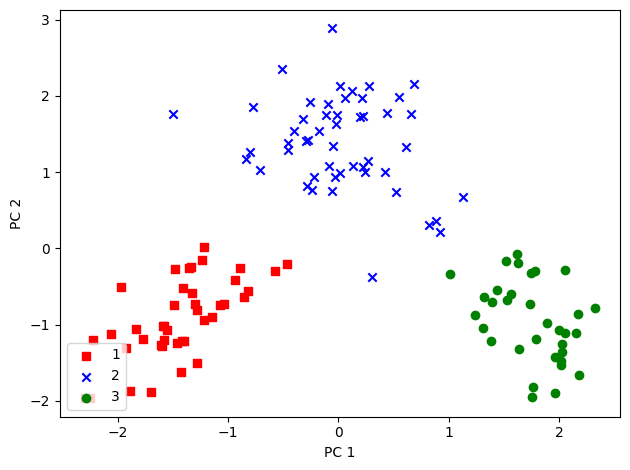

In [15]:
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)

# プロット
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0], 
                X_train_lda[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### `scikit-learn` を利用した LDAの実装

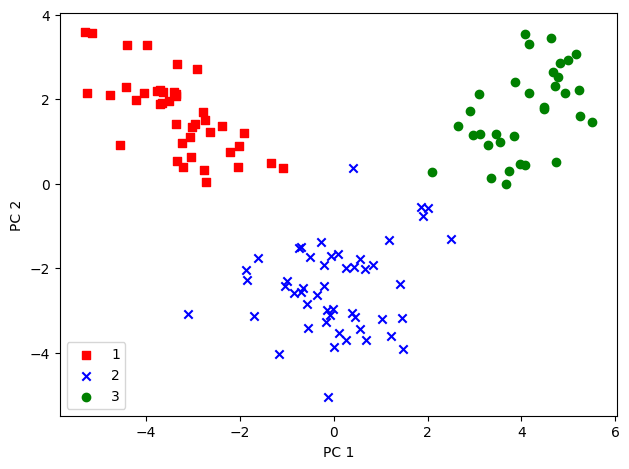

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)

# プロット
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0], 
                X_train_lda[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### LDAを利用したロジスティック回帰

In [17]:
from sklearn.linear_model import LogisticRegression

lda = LDA(n_components=2)

X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

print('Accuracy: %.3f' % lr.score(X_test_lda, y_test))

Accuracy: 1.000


## カーネル主成分分析(KPCA)
RBFカーネルのPCAを実装

In [18]:
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import numpy as np
from numpy import exp


def rbf_kernel_pca(X, gamma, n_components):

    # M x N 次元のデータセットでユーグリット距離の2乗を計算
    sq_dists = pdist(X, 'sqeuclidean')

    # ペアごとの距離を正方行列に変換
    mat_sq_dists = squareform(sq_dists)

    # カーネル行列を計算
    K = exp(-gamma * mat_sq_dists)

    # カーネル行列を中心化
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # 中心化されたカーネル行列から固有対を取得
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # 上位k個の固有ベクトルを収取
    X_pc = np.column_stack([eigvecs[:, i]
                            for i in range(n_components)])

    return X_pc

### make_moons
明らかに線形分離できない半月状のデータを作成して性能を確かめる

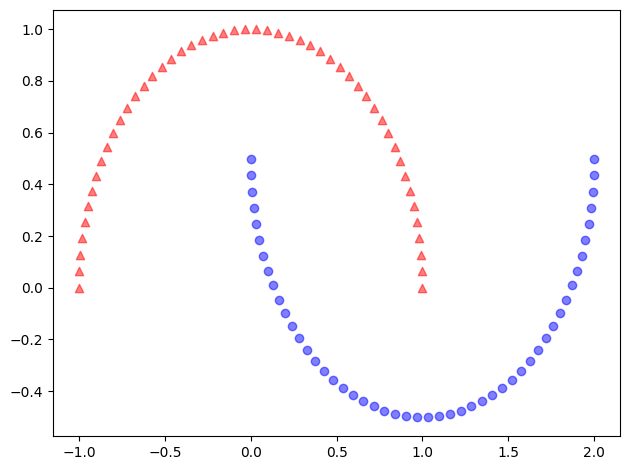

In [19]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
plt.show()

### 標準のPCA
標準のPCAでは線形分離機が十分な性能を出せない形状にしか変換できない

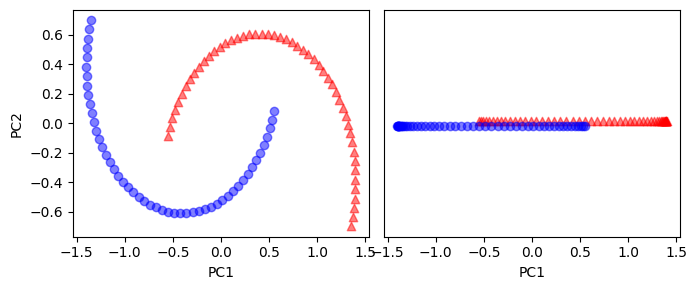

In [20]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

### カーネルPCA
標準のPCAでは線形分離機が十分な性能を出せる形状にしか変換することができている

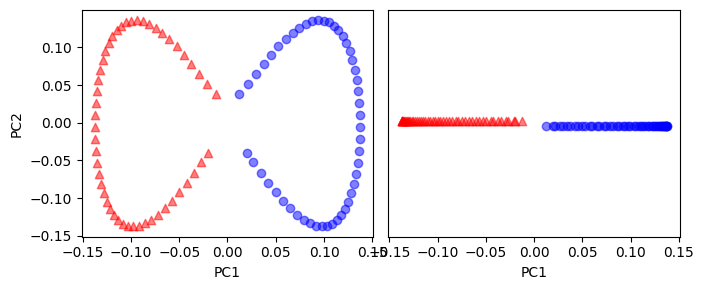

In [21]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50, 1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50, 1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

### scikit-learnでの実装
カーネルPCAはscikit-learnに実装されているので、こちらを利用するのが一般的である。

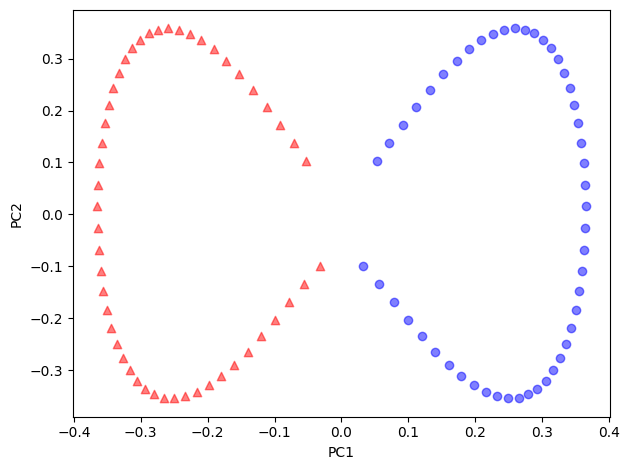

In [22]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
# plt.savefig('images/05_19.png', dpi=300)
plt.show()